In [10]:
import matplotlib.pyplot as plt
import numpy as np
import numpy.fft as fft
import math

In [11]:
def plot_frequency_response(sample_rate, *signals, labels=None, title='Frequency Response', xlim=None, ylim=None, grid=True, figsize=(10, 6)):
    """
    Рисует АЧХ (в dB) для одного или нескольких сигналов.
    
    Параметры:
    sample_rate : float
        Частота дискретизации (Гц)
    *signals : array_like
        Один или несколько массивов с сигналами
    labels : list, optional
        Подписи для легенды (длина должна совпадать с количеством сигналов)
    title : str, optional
        Заголовок графика
    xlim : tuple, optional
        Границы частотной оси (min_freq, max_freq)
    ylim : tuple, optional
        Границы амплитудной оси (min_amp, max_amp)
    grid : bool, optional
        Включить сетку (по умолчанию True)
    figsize : tuple, optional
        Размер графика (ширина, высота)
    """
    
    # Проверка согласованности меток
    if labels is not None and len(labels) != len(signals):
        raise ValueError("Количество меток должно соответствовать количеству сигналов")
    
    plt.figure(figsize=figsize)
    
    for i, signal in enumerate(signals):
        n = len(signal)
        
        # Расчет БПФ и амплитудного спектра
        spectrum = np.fft.rfft(signal)
        magnitude = np.abs(spectrum) / n
        
        # Коррекция амплитуд (кроме нулевой частоты)
        if n > 1:
            magnitude[1:] *= 2
        
        # Преобразование в dB
        magnitude_db = 20 * np.log10(magnitude + 1e-12)  # +1e-12 для избежания log(0)
        
        # Расчет частотной оси
        freqs = np.fft.rfftfreq(n, d=1/sample_rate)
        
        # Построение графика
        label = labels[i] if labels else f'Signal {i+1}'
        plt.plot(freqs, magnitude_db, label=label)
    
    # Настройка оформления
    plt.title(title)
    plt.xlabel('Frequency (Hz)')
    plt.ylabel('Amplitude (dB)')
    plt.grid(grid)
    
    if xlim:
        plt.xlim(xlim)
    else:
        plt.xlim(0, sample_rate/2)  # Автоматические границы до частоты Найквиста
    
    if ylim:
        plt.ylim(ylim)
    
    if len(signals) > 1 or labels:
        plt.legend()
    
    plt.tight_layout()
    plt.show()


In [12]:
def filter_step(omega: float, T: float, x: float, x_prev: float, y_prev: float) -> float:
     return (omega * T* (x + x_prev) - y_prev*(omega*T-2)) / (omega * T + 2) 

In [28]:
FREQ = 44100

TIME = 0.01

SIGNAL = np.linspace(0, TIME, int(TIME* FREQ))
# SIGNAL = np.random.random_sample((1000, ))
SIGNAL = np.real(fft.ifft(10*np.ones((1000, ))))
# SIGNAL = sum( np.sin(SIGNAL * i * 2 * np.pi)  for i in [1000, 2000])
#np.random.normal(0, 0.1, 10000)



In [29]:
omega = 5000
T = 1/FREQ

FILTERED = SIGNAL.copy()
x_prev, y_prev = 0 , 0

for x, i in zip(SIGNAL, range(len(SIGNAL))):
     y = filter_step(omega, T, x, x_prev, y_prev)

     FILTERED[i] = y

     x_prev, y_prev = x, y

In [30]:
СUTOFF = 2000

alpha = 2*np.pi * (СUTOFF / FREQ)

FILTERED = SIGNAL.copy()
x_prev, y_prev = 0 , 0

for x, i in zip(SIGNAL, range(len(SIGNAL))):
     y = alpha / (alpha + 1)*x + 1/(1+alpha)*y_prev

     FILTERED[i] = y

     x_prev, y_prev = x, y


In [33]:
import scipy.signal as signal

fnyc = FREQ / 2
N = 2  # Порядок аналогового прототипа
f_l, f_h = 100 / fnyc, 10000 / fnyc
f_s = FREQ  # Частота дискретизации
b, a = signal.butter(N, [f_l, f_h], btype='bandpass', fs=f_s)

y_prev = [0] * (len(b) - 1)
x_prev = [0] * len(b)

FILTERED = SIGNAL.copy()

print(a, b)

for x, i in zip(SIGNAL, range(len(SIGNAL))):
     x_prev = [x] + x_prev[:-1]
     y = np.dot(x_prev, b) + np.dot(y_prev, a[1:])
     y_prev = [y] + y_prev[:-1]

     FILTERED[i] = y
FILTERED = signal.lfilter(b, a, SIGNAL)


[ 1.         -3.99990953  5.99972861 -3.99972861  0.99990954] [ 1.02295405e-09  0.00000000e+00 -2.04590809e-09  0.00000000e+00
  1.02295405e-09]


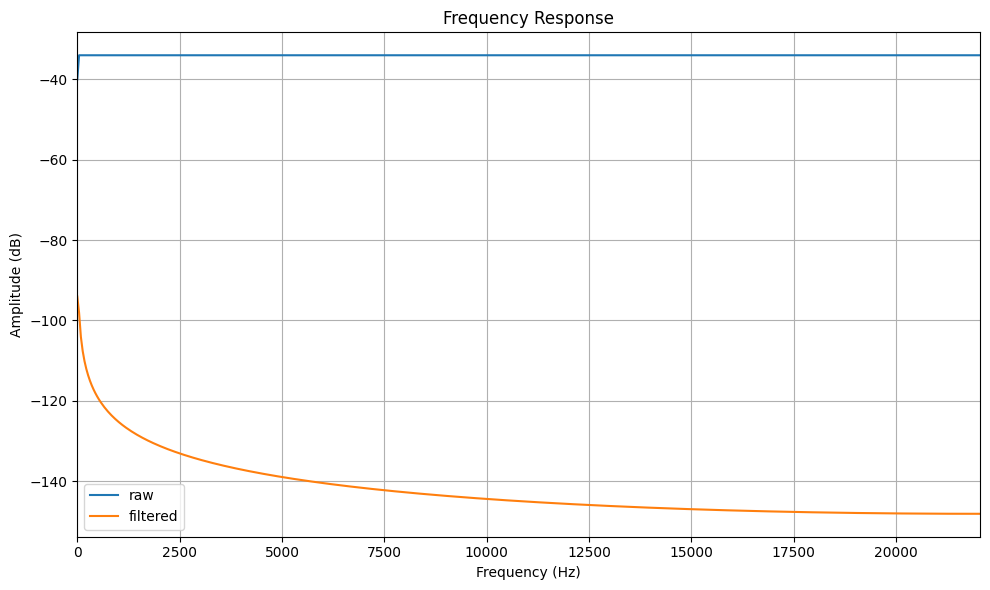

In [34]:
# plt.plot(SIGNAL)
# plt.plot(FILTERED)

# plt.show()

plot_frequency_response(FREQ, SIGNAL, FILTERED, labels=['raw', 'filtered'] )